In [75]:
import pandas as pd

data = pd.read_csv("TokensTest.csv", index_col = 0)
keyTokens = pd.read_csv("NeighbourhoodCountsTrain.csv")
antiTokens = pd.read_csv("AntiNeighbourCountTrain.csv", header = None)
#antiTokens = antiTokens.iloc[:,0].values

print (data.head())
print (keyTokens.head(10))
print (antiTokens.head())

                                                    0
0   bed eight michael wu forty eight year under dr...
1   vera abbott bed four under dr liu come in with...
2   cindy benedictos bed under dr smtih come in fo...
4   ramanathan nisha pillai bed year old under dr ...
11  rebecca birks bed seven yr old under dalianis ...
   Unnamed: 0  N=1  N=2  N=3  N=4  N=5  N=6  N=7   N=8   N=9
0          mg  262  407  492  614  763  851  953  1068  1155
1          on  152  268  315  383  447  505  553   595   625
2       daily  113  187  256  318  379  419  482   527   570
3         day   58  101  124  170  217  245  282   323   352
4  medication   46   61   84  112  139  161  185   204   222
5         for   46   91  127  158  189  220  263   303   341
6          qd   42   62   82   98  120  129  146   162   173
7         prn   40   56   73   92  111  124  136   152   159
8     regular   40   51   60   65   72   73   83    88    91
9         bid   39   68   92  118  145  166  191   210   225
     

In [36]:
# getting to see if the words are nouns, adverbs, adjectives
from nltk.corpus import wordnet as wn

# WordNet POS tags are: NOUN = 'n', ADJ = 's', VERB = 'v', ADV = 'r', ADJ_SAT = 'a'
# Descriptions (c) https://web.stanford.edu/~jurafsky/slp3/10.pdf
tag_map = {
        'JJ':wn.ADJ, # adjective (yellow)                         
        'NN':wn.NOUN, # noun, sing. or mass (llama)          
        'NNS':wn.NOUN, # noun, plural (llamas)                  
}

def get_wordnet_pos(tag):
    try:
        if tag_map[tag] != None:
            return tag_map[tag]
    except:
        return None
    return None

In [37]:
import nltk

def GetNoun (tokens):
    tokens = nltk.pos_tag(tokens)
    output = set()
    for i in tokens:
        if get_wordnet_pos(i[1]) == wn.NOUN:
            output.add(i[0])
    if len(output) >= 0:
        return list(output)

In [85]:
def GetMeds (neighbourhood = 1, numberOfWords = 1, tokenPercentage = 1):
    neighbourHeader = "N="+str(neighbourhood)
    tokenIndex = len(keyTokens)
    antiTokenIndex = len(antiTokens)
    
    keyTokenSorted = keyTokens.sort_values(by = neighbourHeader, ascending=False)
    
    for i in range(len(keyTokenSorted[neighbourHeader])):
        if (keyTokenSorted[neighbourHeader][0:i].sum()/float(keyTokenSorted[neighbourHeader].sum()) >=tokenPercentage):
            tokenIndex = i
            break
    tokenSubset = keyTokenSorted[:tokenIndex]
    
    for i in range(len(antiTokens)):
        if (antiTokens.iloc[0:i,1].sum()/float(antiTokens.iloc[:,1].sum()) >=tokenPercentage):
            antiTokenIndex = i
            break
    antiTokenSubset = antiTokens[:antiTokenIndex]

    meds = [[]]
    counter = 0
    for i in range(len(data)):
        tokenized = data.iloc[i,0].split(" ")
        nouns = []
        for keyToken in tokenSubset.iloc[:,0]:
            try:
                while keyToken in tokenized:
                    keyLocation = tokenized.index(keyToken)
                    tokenWindow = tokenized[max(keyLocation-neighbourhood,0):keyLocation+neighbourhood+1]
                    #tokenWindow = tokenized[keyLocation:keyLocation+neighbourhood+1]
                    tokenWindow.remove(keyToken)
                    for token in tokenWindow:
                        if token in antiTokenSubset.iloc[:,0]:
                            counter += 1
                            break
                    nouns += GetNoun(tokenWindow)
                    tokenized.pop(keyLocation)
            except ValueError:
                pass
        meds += [[",".join(list(set(nouns)))]]  
    print ("tokens removed:",counter)
    print ("tokenSubset:",tokenIndex)
    print ("antiTokenSubset:",antiTokenIndex)
    return meds
            

In [86]:
from AccuracyCalculator import get_metrics
import time

percents = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
precisionRecord = []
recallRecord = []
f1Record = []
runtimeRecord = []

keyTokenSorted = keyTokens.sort_values(by = "N=3", ascending=False)

for i in percents:
    startTime = time.time()
    meds = GetMeds(3, tokenPercentage = i)
    endTime = time.time()

    medsDF = pd.DataFrame(meds)
    medsDF = medsDF.iloc[1:]
    medsDF.index = data.index

    precision, recall, f1 = get_metrics(medsDF)
    precisionRecord += [precision]
    recallRecord += [recall]
    f1Record += [f1]
    runtimeRecord += [endTime-startTime]
    print ("Percent:",i)

tokens removed: 0
tokenSubset: 475
antiTokenSubset: 4281
Percent: 1
tokens removed: 0
tokenSubset: 209
antiTokenSubset: 1853
Percent: 0.9
tokens removed: 0
tokenSubset: 112
antiTokenSubset: 923
Percent: 0.8
tokens removed: 0
tokenSubset: 64
antiTokenSubset: 508
Percent: 0.7
tokens removed: 0
tokenSubset: 36
antiTokenSubset: 299
Percent: 0.6
tokens removed: 0
tokenSubset: 20
antiTokenSubset: 175
Percent: 0.5
tokens removed: 0
tokenSubset: 11
antiTokenSubset: 95
Percent: 0.4
tokens removed: 0
tokenSubset: 6
antiTokenSubset: 45
Percent: 0.3
tokens removed: 0
tokenSubset: 3
antiTokenSubset: 17
Percent: 0.2
tokens removed: 0
tokenSubset: 1
antiTokenSubset: 5
Percent: 0.1


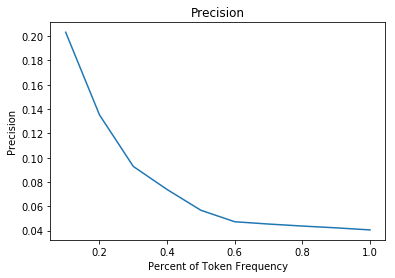

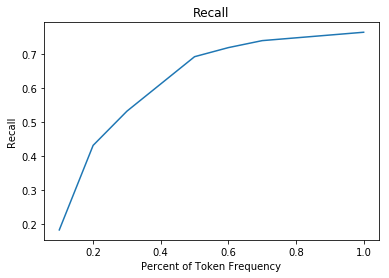

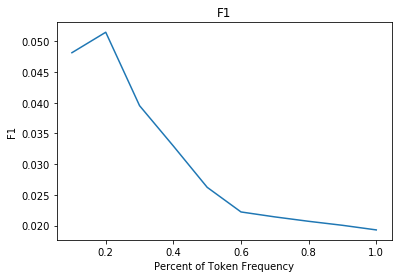

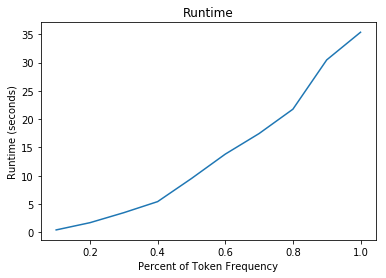

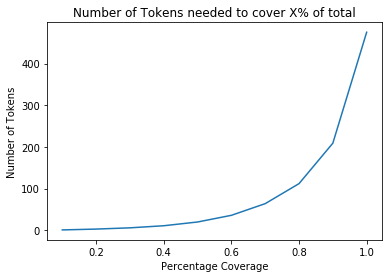

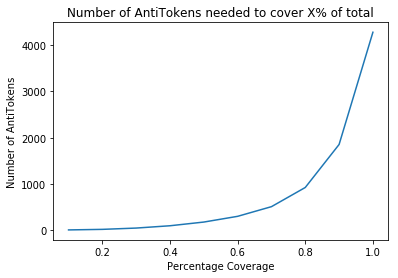

In [92]:
import matplotlib.pyplot as plt

tokenCountRecord = [475,209,112,64,36,20,11,6,3,1]
antiTokenCountRecord = [4281,1853,923,508,299,175,95,45,17,5]

plt.plot (percents,precisionRecord)
plt.xlabel ("Percent of Token Frequency")
plt.ylabel ("Precision")
plt.title("Precision")
plt.show()
plt.plot (percents,recallRecord)
plt.xlabel ("Percent of Token Frequency")
plt.ylabel ("Recall")
plt.title("Recall")
plt.show()
plt.plot (percents,f1Record)
plt.xlabel ("Percent of Token Frequency")
plt.ylabel ("F1")
plt.title("F1")
plt.show()
plt.plot (percents,runtimeRecord)
plt.xlabel ("Percent of Token Frequency")
plt.ylabel ("Runtime (seconds)")
plt.title("Runtime")
plt.show()
plt.plot (percents,tokenCountRecord)
plt.xlabel ("Percentage Coverage")
plt.ylabel ("Number of Tokens")
plt.title("Number of Tokens needed to cover X% of total")
plt.show()
plt.plot (percents,antiTokenCountRecord)
plt.xlabel ("Percentage Coverage")
plt.ylabel ("Number of AntiTokens")
plt.title("Number of AntiTokens needed to cover X% of total")
plt.show()

In [77]:
tags = nltk.pos_tag(['vera', 'abbott', 'bed', 'four', 'under'])
print (tags)
print (GetNoun(['vera', 'abbott', 'bed', 'four', 'under']))

[('vera', 'NN'), ('abbott', 'NN'), ('bed', 'VBD'), ('four', 'CD'), ('under', 'IN')]
{'vera'}
{'vera', 'abbott'}


TypeError: '>=' not supported between instances of 'set' and 'int'

In [59]:
range(1,0.5,0.1)

TypeError: 'float' object cannot be interpreted as an integer